In [1]:
!nvidia-smi

Mon Nov 14 16:57:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from tensorflow.keras.datasets import mnist
import numpy as np

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train.shape, X_test.shape

11490434/11490434 [==============================] - 2s 0us/step


((60000, 28, 28), (10000, 28, 28))

In [3]:
X_train = X_train.astype('float32')/255
X_test = X_test.astype('float32')/255

In [4]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization, Activation, Flatten, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

input_img = Input(shape=(28, 28, 1))

x = Conv2D(8, (3, 3), padding='same')(input_img)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = MaxPooling2D((2, 2), padding='same')(x)

x = Flatten()(x)
x = Dense(128)(x)     # at this point the representation is 128-dimensional
x = BatchNormalization()(x)
x = Activation('elu')(x)

x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)

x = Reshape((4, 4, 32))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), padding='same')(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3))(x)
x = BatchNormalization()(x)
x = Activation('elu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 8)         80        
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 8)        32        
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 28, 28, 8)         0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 16)        1168  

In [5]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = autoencoder.fit(X_train, X_train,
                        epochs=100,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(X_test, X_test),
                        callbacks = EarlyStopping(monitor="val_loss", patience=5))

Epoch 1/100
235/235 [==============================] - 15s 21ms/step - loss: 0.2557 - accuracy: 0.7721 - val_loss: 0.2257 - val_accuracy: 0.8093
Epoch 2/100
235/235 [==============================] - 3s 15ms/step - loss: 0.1026 - accuracy: 0.8132 - val_loss: 0.1030 - val_accuracy: 0.8113
Epoch 3/100
235/235 [==============================] - 4s 16ms/step - loss: 0.0902 - accuracy: 0.8142 - val_loss: 0.0917 - val_accuracy: 0.8126
Epoch 4/100
235/235 [==============================] - 3s 11ms/step - loss: 0.0855 - accuracy: 0.8145 - val_loss: 0.0857 - val_accuracy: 0.8133
Epoch 5/100
235/235 [==============================] - 2s 10ms/step - loss: 0.0829 - accuracy: 0.8147 - val_loss: 0.0819 - val_accuracy: 0.8137
Epoch 6/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0809 - accuracy: 0.8148 - val_loss: 0.0812 - val_accuracy: 0.8137
Epoch 7/100
235/235 [==============================] - 2s 9ms/step - loss: 0.0797 - accuracy: 0.8149 - val_loss: 0.0804 - val_accuracy: 

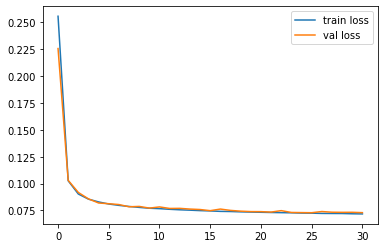

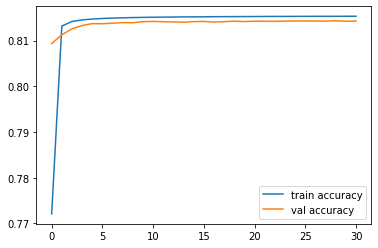

In [6]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()

In [7]:
decoded_imgs = autoencoder.predict(X_test[:10000])

313/313 [==============================] - 1s 3ms/step


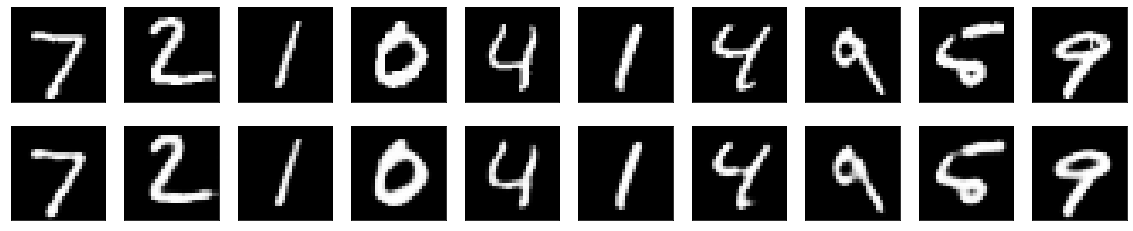

In [8]:
n = 10  
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
autoencoder.save('autoencoder.h5')

In [11]:
latent_space = autoencoder.get_layer('activation_3').output
latent_space_model = Model(input_img, latent_space)
# latent_space_model.save('latent_space_model.h5')

latent_space_data = latent_space_model.predict(X_test[:10000]).reshape(10000, 128)

latent_space_data.shape

313/313 [==============================] - 1s 2ms/step


(10000, 128)

In [12]:
latent_space_data[0].shape

(128,)

In [19]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

def getImage(img):
   return OffsetImage(img, zoom=0.1)

<Figure size 9000x4500 with 0 Axes>

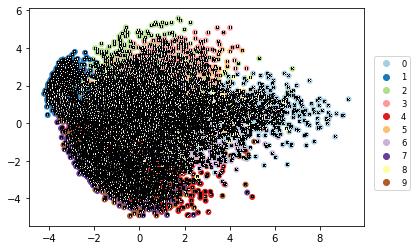

In [45]:
from sklearn.decomposition import PCA

pca_original = PCA(n_components=2)
trans_pca_original = pca_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_pca_original[:,0], trans_pca_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_pca_original[:,0], trans_pca_original[:,1], edgecolors = 'none', c = y_test[:10000], cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_pca.png', dpi = 300)
plt.show()

<Figure size 9000x4500 with 0 Axes>

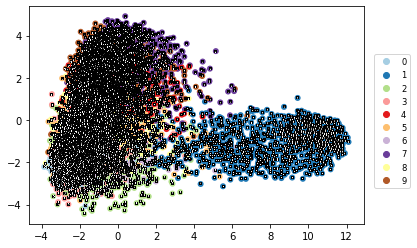

In [46]:
pca_latent_space = PCA(n_components=2)
trans_pca_latent_space = pca_latent_space.fit_transform(latent_space_data[:10000].reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_pca_latent_space[:,0], trans_pca_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_pca_latent_space[:,0], trans_pca_latent_space[:,1], edgecolors = 'none', c = y_test[:10000], cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_pca.png', dpi = 300)
plt.show()

<Figure size 9000x4500 with 0 Axes>

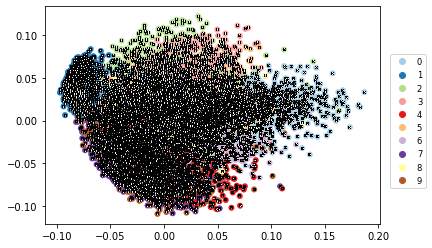

In [52]:
from sklearn.decomposition import KernelPCA

kpca_original = KernelPCA(n_components=2, kernel='sigmoid')
trans_kpca_original = kpca_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_kpca_original[:,0], trans_kpca_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_kpca_original[:,0], trans_kpca_original[:,1], edgecolors = 'none', c = y_test[:10000], cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_pca.png', dpi = 300)
plt.show()

<Figure size 9000x4500 with 0 Axes>

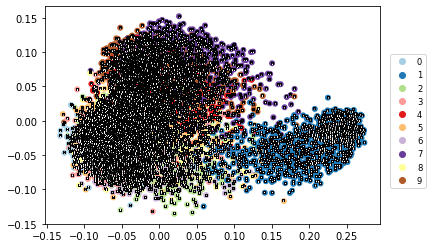

In [51]:
kpca_latent_space = KernelPCA(n_components=2, kernel='sigmoid')
trans_kpca_latent_space = kpca_latent_space.fit_transform(latent_space_data[:10000].reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_kpca_latent_space[:,0], trans_kpca_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_kpca_latent_space[:,0], trans_kpca_latent_space[:,1], edgecolors = 'none', c = y_test[:10000], cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_pca.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

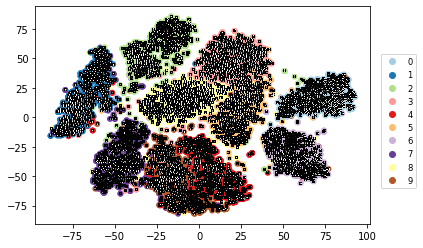

In [20]:
from sklearn.manifold import TSNE

tsne_original = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=25)
trans_tsne_original = tsne_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_original[:,0], trans_tsne_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_original[:,0], trans_tsne_original[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_tsne_perplexity_25.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

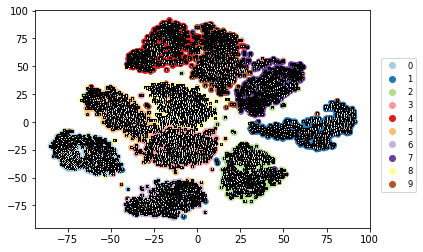

In [21]:
tsne_latent_space = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=25)
trans_tsne_latent_space = tsne_latent_space.fit_transform(latent_space_data.reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_tsne_perplexity_25.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

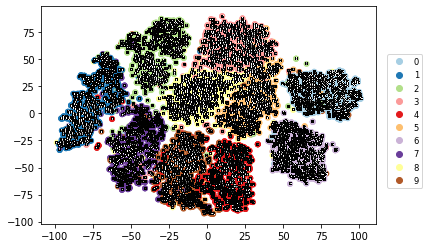

In [22]:
from sklearn.manifold import TSNE

tsne_original = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=15)
trans_tsne_original = tsne_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_original[:,0], trans_tsne_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_original[:,0], trans_tsne_original[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_tsne_perplexity_15.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

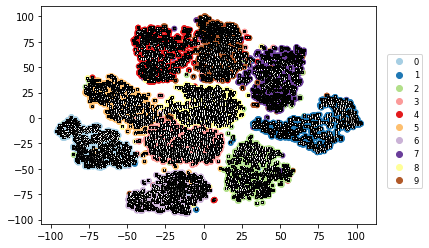

In [23]:
tsne_latent_space = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=15)
trans_tsne_latent_space = tsne_latent_space.fit_transform(latent_space_data.reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_tsne_perplexity_15.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

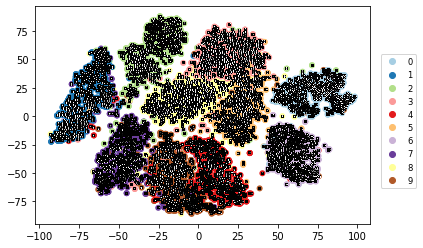

In [24]:
from sklearn.manifold import TSNE

tsne_original = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=20)
trans_tsne_original = tsne_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_original[:,0], trans_tsne_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_original[:,0], trans_tsne_original[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_tsne_perplexity_20.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

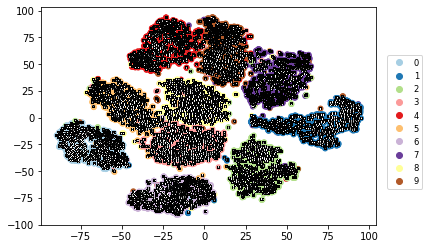

In [25]:
tsne_latent_space = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=20)
trans_tsne_latent_space = tsne_latent_space.fit_transform(latent_space_data.reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_tsne_perplexity_20.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

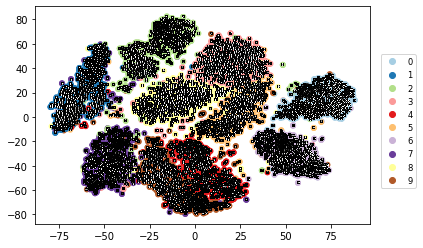

In [26]:
from sklearn.manifold import TSNE

tsne_original = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
trans_tsne_original = tsne_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_original[:,0], trans_tsne_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_original[:,0], trans_tsne_original[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_tsne_perplexity_30.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

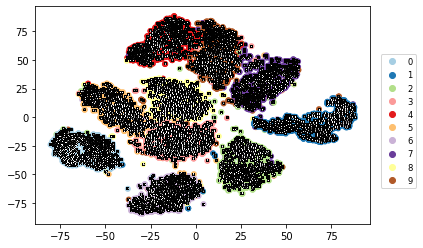

In [27]:
tsne_latent_space = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=30)
trans_tsne_latent_space = tsne_latent_space.fit_transform(latent_space_data.reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_tsne_perplexity_30.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

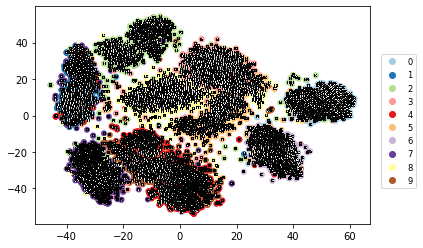

In [28]:
from sklearn.manifold import TSNE

tsne_original = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=100)
trans_tsne_original = tsne_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_original[:,0], trans_tsne_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_original[:,0], trans_tsne_original[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_tsne_perplexity_100.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

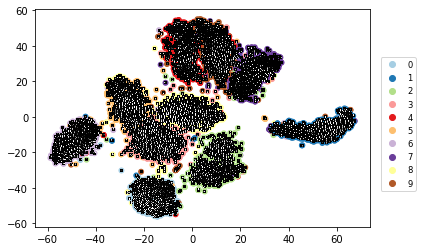

In [29]:
tsne_latent_space = TSNE(n_components=2, learning_rate='auto', init='pca', perplexity=100)
trans_tsne_latent_space = tsne_latent_space.fit_transform(latent_space_data.reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_tsne_perplexity_100.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

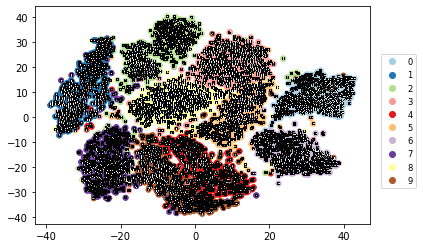

In [30]:
from sklearn.manifold import TSNE

tsne_original = TSNE(n_components=2, init="pca", learning_rate="auto", n_iter=500, n_iter_without_progress=150, n_jobs=2, random_state=0)
trans_tsne_original = tsne_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_original[:,0], trans_tsne_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_original[:,0], trans_tsne_original[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_tsne_n_iter_500_n_iter_without_progress_150.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

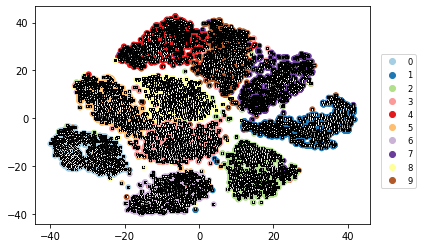

In [31]:
tsne_latent_space = TSNE(n_components=2, init="pca", learning_rate="auto", n_iter=500, n_iter_without_progress=150, n_jobs=2, random_state=0)
trans_tsne_latent_space = tsne_latent_space.fit_transform(latent_space_data.reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_tsne_n_iter_500_n_iter_without_progress_150.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

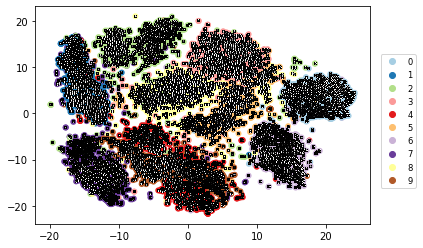

In [32]:
from sklearn.manifold import TSNE

tsne_original = TSNE(n_components=2, init="pca", random_state=0, perplexity=100, learning_rate="auto", n_iter=400)
trans_tsne_original = tsne_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_original[:,0], trans_tsne_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_original[:,0], trans_tsne_original[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_tsne_perplexity_100_n_iter_400.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

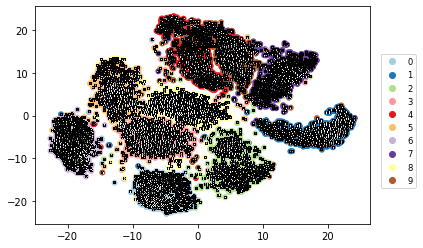

In [33]:
tsne_latent_space = TSNE(n_components=2, init="pca", random_state=0, perplexity=100, learning_rate="auto", n_iter=400)
trans_tsne_latent_space = tsne_latent_space.fit_transform(latent_space_data.reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_tsne_perplexity_100_n_iter_400.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

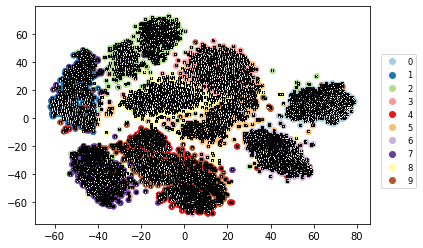

In [41]:
from sklearn.manifold import TSNE

tsne_original = TSNE(n_components=2, init="pca", random_state=0, perplexity=50)
trans_tsne_original = tsne_original.fit_transform(X_test[:10000].reshape(10000, 784))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_original[:,0], trans_tsne_original[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_original[:,0], trans_tsne_original[:,1], edgecolors = 'none', c = y_test, cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_784_tsne_perplexity_50.png', dpi = 300)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


<Figure size 9000x4500 with 0 Axes>

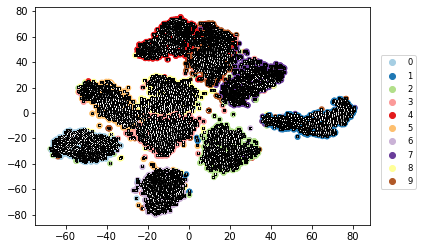

In [42]:
tsne_latent_space = TSNE(n_components=2, init="pca", random_state=0, perplexity=50)
trans_tsne_latent_space = tsne_latent_space.fit_transform(latent_space_data.reshape(10000, 128))

plt.figure(figsize = (30, 15), dpi = 300) 
fig, ax = plt.subplots()

c = 0
for x0, y0 in zip(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1]):
   ab = AnnotationBbox(getImage(X_test[c]), (x0, y0), frameon=False)
   c += 1
   ax.add_artist(ab)

scatter = plt.scatter(trans_tsne_latent_space[:,0], trans_tsne_latent_space[:,1], edgecolors = 'none', c = y_test[:10000], cmap = 'Paired')
plt.legend(handles=scatter.legend_elements()[0], labels = list(map(str, np.unique(y_test))), bbox_to_anchor = (1.15, 0.8), fontsize = 'small')
plt.savefig('img_128_tsne_perplexity_50.png', dpi = 300)
plt.show()

In [53]:
!rm -rf /content/sample_data

In [60]:
!zip -r /content/autoencoder.zip /content/*

  adding: content/autoencoder.h5 (deflated 15%)
  adding: content/img_128_pca.png (deflated 5%)
  adding: content/img_128_tsne_n_iter_500_n_iter_without_progress_150.png (deflated 6%)
  adding: content/img_128_tsne_perplexity_100_n_iter_400.png (deflated 6%)
  adding: content/img_128_tsne_perplexity_100.png (deflated 7%)
  adding: content/img_128_tsne_perplexity_15.png (deflated 6%)
  adding: content/img_128_tsne_perplexity_20.png (deflated 7%)
  adding: content/img_128_tsne_perplexity_25.png (deflated 7%)
  adding: content/img_128_tsne_perplexity_30.png (deflated 7%)
  adding: content/img_128_tsne_perplexity_50.png (deflated 7%)
  adding: content/img_784_pca.png (deflated 6%)
  adding: content/img_784_tsne_n_iter_500_n_iter_without_progress_150.png (deflated 6%)
  adding: content/img_784_tsne_perplexity_100_n_iter_400.png (deflated 6%)
  adding: content/img_784_tsne_perplexity_100.png (deflated 6%)
  adding: content/img_784_tsne_perplexity_15.png (deflated 6%)
  adding: content/img_78